# HODMD applied to the density matrix computed from RT-TDDFT

In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from dmd import dmd, plot_tools
from dmd.tools.utils import sort_complex_array

plt.rcParams.update(plot_tools.plotparams)


## Helper functions

In [2]:
def compute_dipole_mol(dipole_ao, c_matrix_complete):
    """
    Compute the dipole moment in the molecular basis
    """

    nstate = c_matrix_complete.shape[1]

    dipole_mol = np.zeros((nstate, nstate, 3), dtype=float)
    for idir in range(3):
        dipole_mol[:, :, idir] = c_matrix_complete.T @ dipole_ao[:, :, idir] @ c_matrix_complete

    return dipole_mol


def compute_dipole_from_PD_MO(PD_MO_time):

    nsnap = PD_MO_time.shape[2]
    dipole_time = np.zeros((3, nsnap), dtype=float)

    for idir in range(3):
        dipole_time[idir, :] = - np.sum(PD_MO_time[idir, :, :], axis=0)

    return dipole_time


## Read RT-TDDFT data

In [3]:
def read_rt_tddft(filepath):
    """
    Read the RT-TDDFT HDF5 file

    Parameters
    ----------

    filepath : str
        Path to the HDF5 file

    Returns
    -------

    time_data : np.ndarray
        Array with the time-dependent data from the RT-TDDFT calculation.
        Shape is (3, nocc*nvirt, nsnap)

    time_step : float
        Time step in atomic units.

    nocc : int
        Number of occupied orbitals.

    nvirt : int
        Number of virtual orbitals.
    """

    cdyna_file = h5py.File(filepath, 'r')

    # Number of time snapshots
    nsnap = cdyna_file['nsnap'][()]

    # Number of states
    nstate = cdyna_file['nstate'][()]

    # Time step
    time_step = cdyna_file['time_step'][()]

    # Dipole moment in AO basis
    dipole_ao = cdyna_file['dipole_ao'][()]
    dipole_ao = np.transpose(dipole_ao, axes=(2, 1, 0))

    # Wavefunction coefficients at t=0
    c_matrix_complete = cdyna_file['c_matrix_complete_0_real'][()][0, :, :].T

    # PD in MO basis
    p_matrix_MO_block_0 = cdyna_file['p_matrix_MO_block']['snap_0']

    nspin, nvirt, nocc = p_matrix_MO_block_0.shape
    p_matrix_MO_block_time = np.zeros((nocc, nvirt, nsnap), dtype=float)

    for isnap in range(nsnap):
        p_matrix_MO_block_time[:, :, isnap] = cdyna_file['p_matrix_MO_block'][f'snap_{isnap}'][()][0, :, :].T

    # Dipole moment in MO basis
    dipole_mol = compute_dipole_mol(dipole_ao, c_matrix_complete)
    # Multiply the off-diagonal elements by 2
    mask = ~np.eye(nstate, dtype=bool)[:, :]
    dipole_mol2 = dipole_mol.copy()
    dipole_mol2[mask] *= 2.0
    # Reshape the dipole moment similarly, but without time
    dipole_mol_block = dipole_mol2[:nocc, nocc:, :]
    dipole_mol_block = np.reshape(dipole_mol_block, (nocc * nvirt, 3))

    # Compute the PD matrix
    time_data = np.zeros((3, nocc * nvirt, nsnap), dtype=float)
    au_debye = 2.54174623105

    for idir in range(3):
        time_data[idir, :, :] = p_matrix_MO_block_time * dipole_mol_block[:, idir, np.newaxis] * au_debye

    cdyna_file.close()

    print(f'{time_data.shape=}')
    print(f'{time_data.shape[0]} directions, {time_data.shape[1]} "spatial" points, and {time_data.shape[2]} time snapshots')

    return time_data, time_step, nocc, nvirt

In [4]:
# Save data for the tests reference
save_data = True
#save_data = False

filename = 'H2_rt_tddft.h5'
filepath = os.path.join('../tests/refs', filename)

time_data, time_step, nocc, nvirt = read_rt_tddft(filepath)


time_data.shape=(3, 181, 700)
3 directions, 181 "spatial" points, and 700 time snapshots


## Find largest elements in time_data and plot


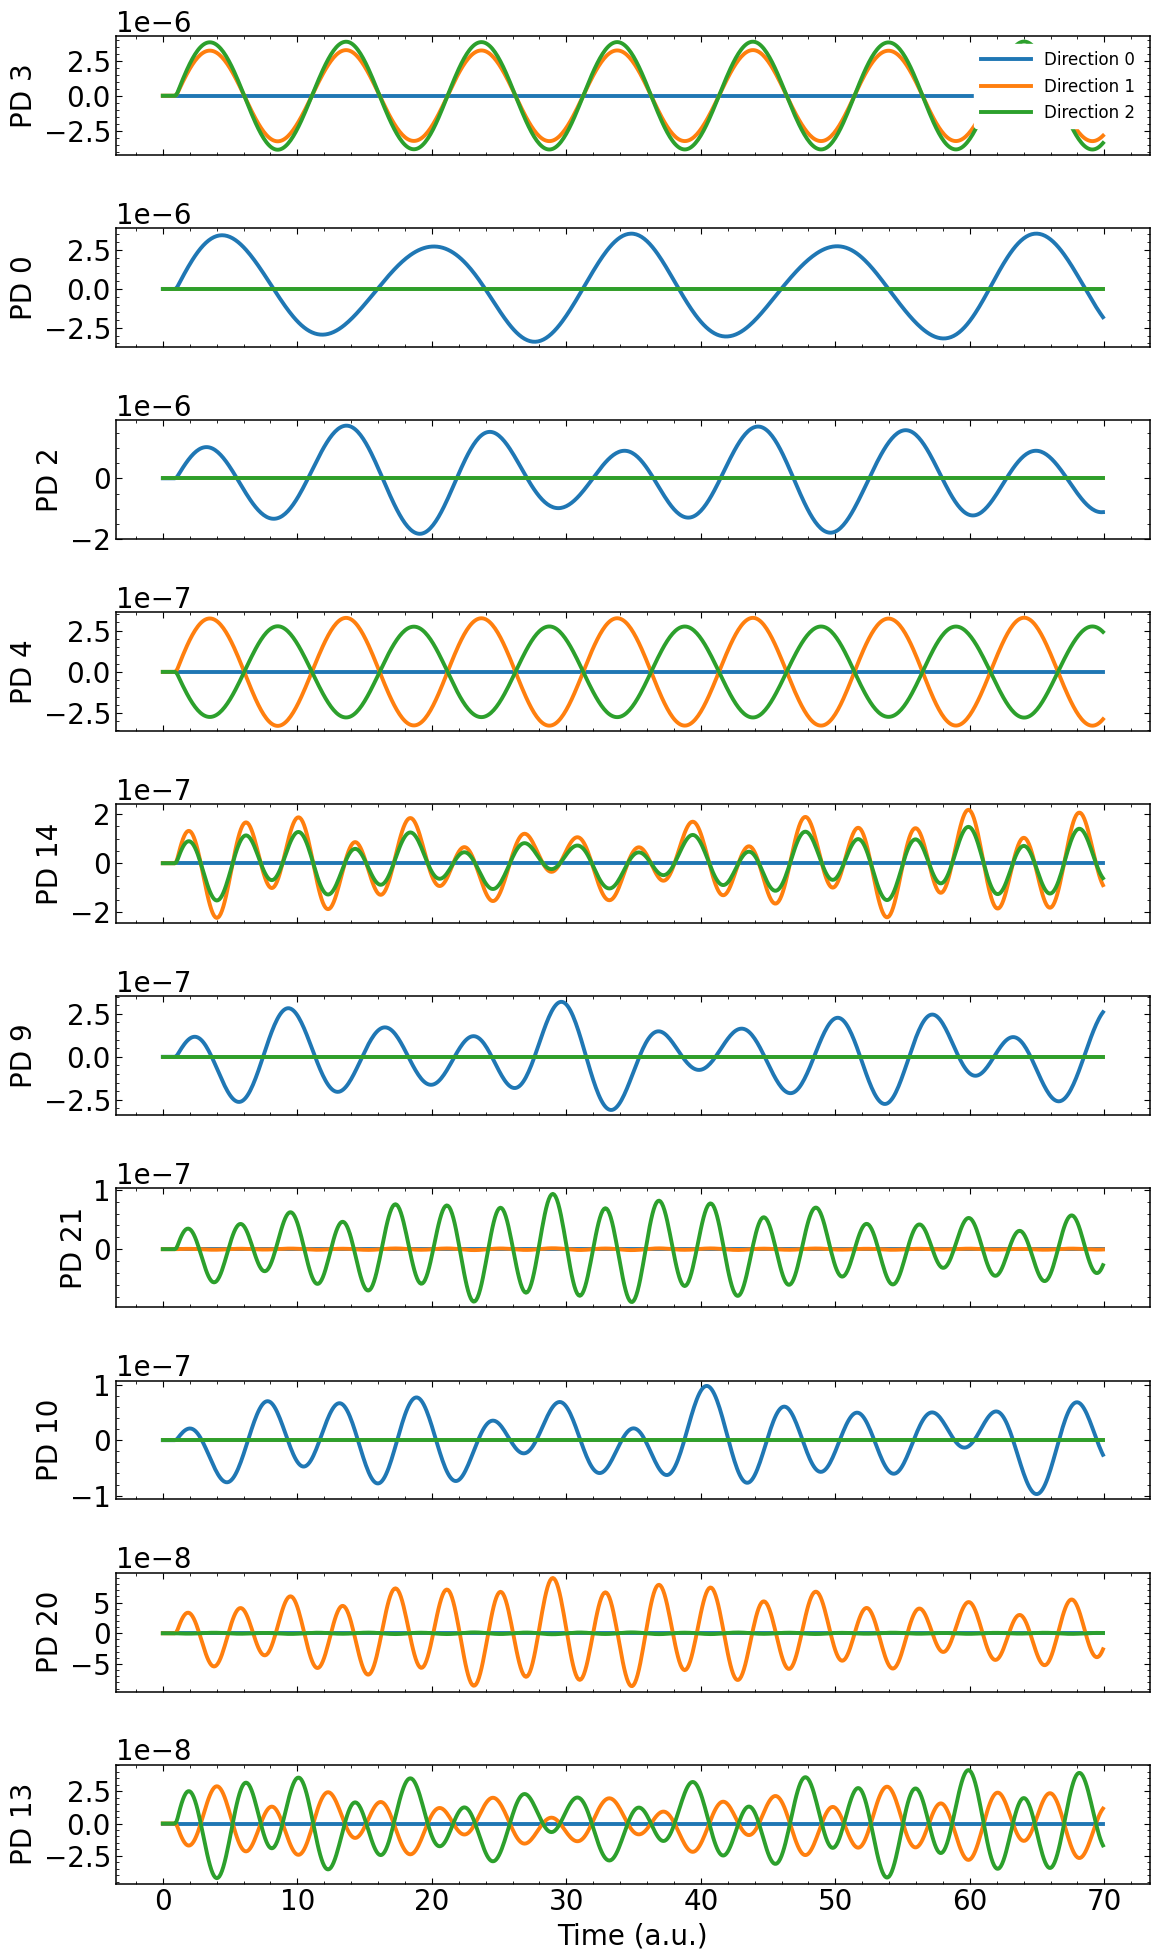

In [5]:
# Sum over directions
time_data_sum = np.sum(np.abs(time_data), axis=0)
# Sum over time snapshots
time_data_sum = np.sum(time_data_sum, axis=1)
# Sort the elements in decreasing HODMD_HODMD_order
idx = np.argsort(time_data_sum)[::-1]
time_data_sum_sorted = time_data_sum[idx]

nfirst = 10
fig, axes = plt.subplots(nfirst, 1, figsize=(12, nfirst * 2), sharex=True)
plt.subplots_adjust(hspace=0.05)

time_array = np.arange(time_data.shape[2]) * time_step

for i in range(nfirst):

    for idir in range(3):
        if i==0:
            label = f'Direction {idir}'
        else:
            label = None

        axes[i].plot(time_array, time_data[idir, idx[i], :], label=label)

    if i==0:
        axes[i].legend(loc='upper right', edgecolor='white', framealpha=1.0, fontsize=12)

    axes[i].set_ylabel(f'PD {idx[i]}')

axes[-1].set_xlabel('Time (a.u.)')

plt.tight_layout()
plt.show()


## Compute the dipole moment

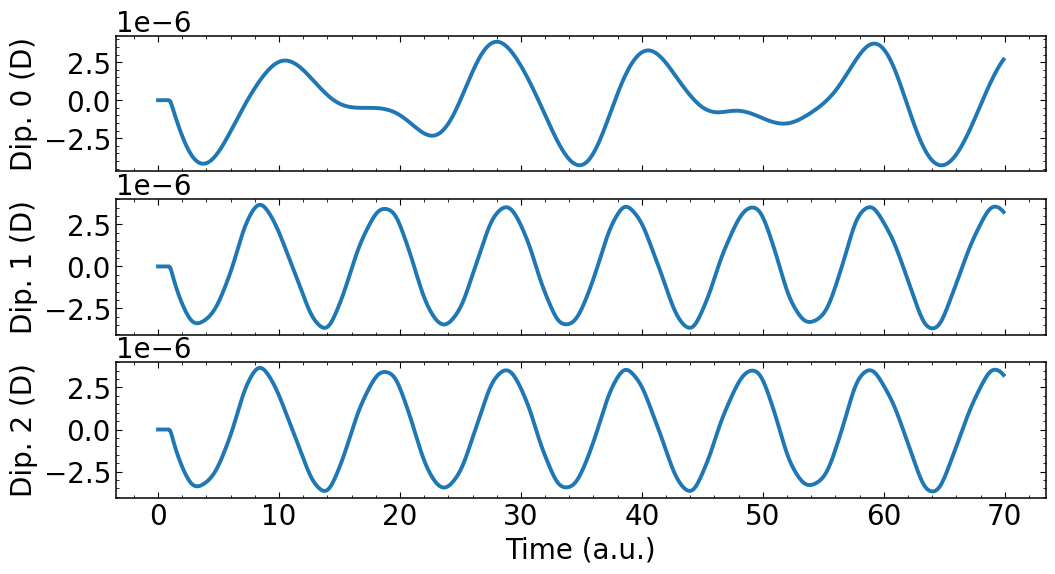

In [6]:
dipole_time = compute_dipole_from_PD_MO(time_data)

fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for idir in range(3):
    ax[idir].plot(time_array, dipole_time[idir, :])
    ax[idir].set_ylabel(f'Dip. {idir} (D)')

ax[-1].set_xlabel('Time (a.u.)')
plt.show()


## First-order DMD

In [7]:
# Number of time snapshots for DMD
ndmd = 110

# First snap for DMD
idmd_first = 15

# Extrapolate for nsnap_extrap time snapshots
nsnap_extrap = 1500

print(time_data.shape)

time_data_extrap = np.zeros((3, time_data.shape[1], nsnap_extrap), dtype=float)

for idir in range(3):
    dmd_obj = dmd.dmd(time_data[idir, :, idmd_first : idmd_first + ndmd])

    dmd_obj.time_step = time_step
    dmd_obj.verbose = True

    dmd_obj.sig_threshold = 1e-7

    dmd_obj.HODMD_order = 1
    dmd_obj.HODMD_ntshift = 1

    dmd_obj.compute_modes()

    dmd_obj.nsnap_extrap = nsnap_extrap

    time_data_extrap[idir, :, :] = dmd_obj.extrapolate().real

    if idir == 0 and save_data:
        with open('dmd_H2_omega_array.npy', 'wb') as f:
            np.save(f, dmd_obj.omega_array)

        with open('dmd_H2_mode_array.npy', 'wb') as f:
            np.save(f, dmd_obj.mode_array)

        with open('dmd_H2_mode_ampl_array.npy', 'wb') as f:
            np.save(f, dmd_obj.mode_ampl_array)

        with open('dmd_H2_sigma_full_array.npy', 'wb') as f:
            np.save(f, dmd_obj.sigma_full_array)

        # Extrapolation: dipole moment
        with open('dmd_H2_extrap_array.npy', 'wb') as f:
            np.save(f, np.sum(time_data_extrap[0, :, :], axis=0))

(3, 181, 700)

Computing DMD modes...

===Size of snap matrix (181, 110)   float64 : 155.547 KB
SVD on X1...
Rank: 21
Done: 0.044 s

Compute the A matrix...

===Size of matrix A   (21, 21)     float64 :  3.445 KB
===Size of matrix U   (181, 21)    float64 : 29.695 KB
===Size of matrix V   (109, 21)    float64 : 17.883 KB

Diago of the A matrix...

Compute the DMD modes Psi...

===Size of mode_array (181, 21)    complex128: 59.391 KB
Compute mode amplitudes b...

Extrapolating dynamics for 1500 snaps...
Memory required for DMD_traj: 0.00405 GB
===Size of DMD_traj   (181, 1500)  complex128:  4.143 MB

Computing DMD modes...

===Size of snap matrix (181, 110)   float64 : 155.547 KB
SVD on X1...
Rank: 15
Done: 0.007 s

Compute the A matrix...

===Size of matrix A   (15, 15)     float64 :  1.758 KB
===Size of matrix U   (181, 15)    float64 : 21.211 KB
===Size of matrix V   (109, 15)    float64 : 12.773 KB

Diago of the A matrix...

Compute the DMD modes Psi...

===Size of mode_array (181, 

## Plot extrapolated data

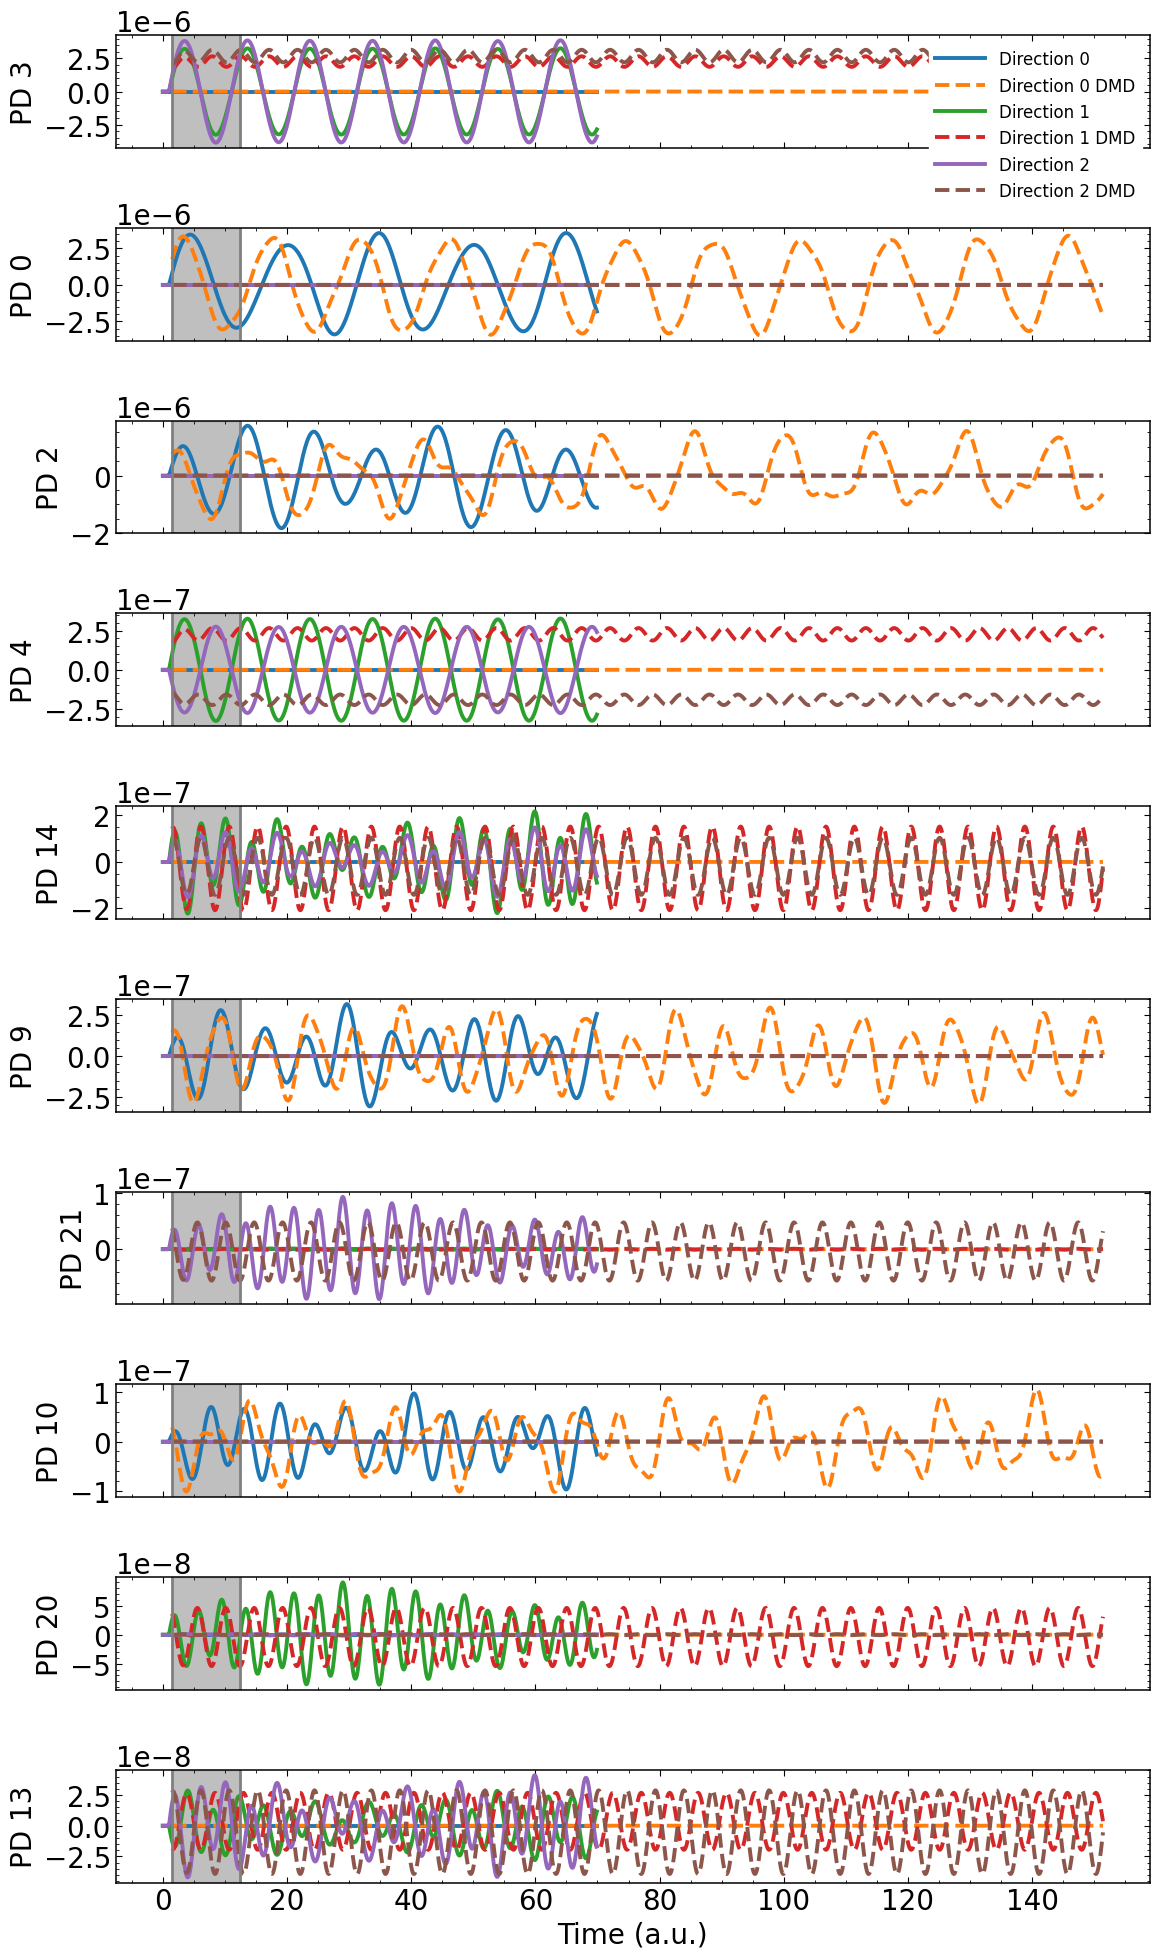

In [8]:
nfirst = 10
fig, axes = plt.subplots(nfirst, 1, figsize=(12, nfirst * 2), sharex=True)
plt.subplots_adjust(hspace=0.05)

time_array_extrap = np.arange(nsnap_extrap) * time_step + idmd_first * time_step

for i in range(nfirst):

    for idir in range(3):
        if i==0:
            label = f'Direction {idir}'
        else:
            label = None

        axes[i].plot(time_array, time_data[idir, idx[i], :], label=label)
        label_extrap = f'Direction {idir} DMD' if label is not None else None
        axes[i].plot(time_array_extrap, time_data_extrap[idir, idx[i], :], label=label_extrap, linestyle='--')

    if i==0:
        axes[i].legend(loc='upper right', edgecolor='white', framealpha=1.0, fontsize=12)

    # Gray region from idmd_first to idmd_first + ndmd with bounds
    axes[i].axvline(idmd_first * time_step, color='gray', linestyle='-', lw=2.0)
    axes[i].axvline((idmd_first + ndmd) * time_step, color='gray', linestyle='-', lw=2.0)
    axes[i].axvspan(idmd_first * time_step, (idmd_first + ndmd) * time_step, color='gray', alpha=0.5)

    axes[i].set_ylabel(f'PD {idx[i]}')

axes[-1].set_xlabel('Time (a.u.)')

plt.tight_layout()
plt.show()

## Plot dipole moments

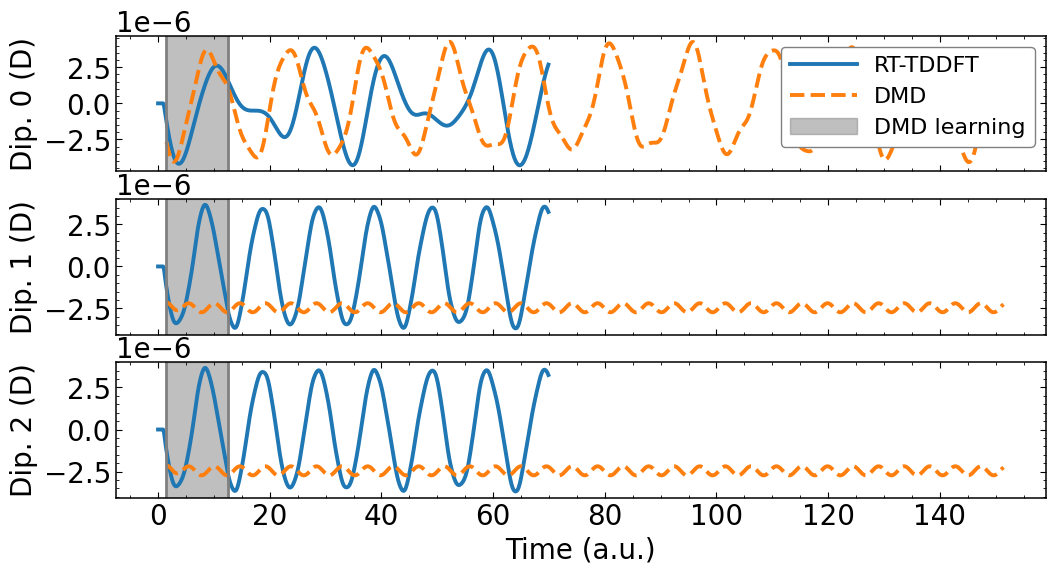

In [9]:
dipole_time_extrap = compute_dipole_from_PD_MO(time_data_extrap)

fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for idir in range(3):
    ax[idir].plot(time_array, dipole_time[idir, :], label='RT-TDDFT')
    ax[idir].plot(time_array_extrap, dipole_time_extrap[idir, :], linestyle='--', label='DMD')
    ax[idir].set_ylabel(f'Dip. {idir} (D)')

    # Gray region from idmd_first to idmd_first + ndmd with bounds
    ax[idir].axvline(idmd_first * time_step, color='gray', linestyle='-', lw=2.0)
    ax[idir].axvline((idmd_first + ndmd) * time_step, color='gray', linestyle='-', lw=2.0)
    ax[idir].axvspan(idmd_first * time_step, (idmd_first + ndmd) * time_step, color='gray', alpha=0.5, label='DMD learning')

ax[0].legend(loc='upper right', edgecolor='gray', framealpha=1.0, fontsize=16)
ax[-1].set_xlabel('Time (a.u.)')
plt.show()

## High-order DMD

In [10]:
time_data_extrap_HO = np.zeros((3, time_data.shape[1], nsnap_extrap), dtype=float)
HODMD_obj_list = []

for idir in range(3):
    dmd_obj = dmd.dmd(time_data[idir, :, idmd_first : idmd_first + ndmd])

    dmd_obj.time_step = time_step
    dmd_obj.verbose = True

    dmd_obj.sig_threshold = 1e-7

    dmd_obj.HODMD_order = 2
    dmd_obj.HODMD_ntshift = 1

    dmd_obj.compute_modes()

    dmd_obj.nsnap_extrap = nsnap_extrap

    HODMD_obj_list.append(dmd_obj)

    time_data_extrap_HO[idir, :, :] = dmd_obj.extrapolate()

    if idir == 0 and save_data:

        with open('hodmd_H2_extrap_array.npy', 'wb') as f:
            np.save(f, np.sum(time_data_extrap_HO[0, :, :], axis=0))

        with open('hodmd_H2_omega_array.npy', 'wb') as f:
            np.save(f, dmd_obj.omega_array)

        with open('hodmd_H2_mode_array.npy', 'wb') as f:
            np.save(f, dmd_obj.mode_array)

        with open('hodmd_H2_mode_ampl_array.npy', 'wb') as f:
            np.save(f, dmd_obj.mode_ampl_array)

        with open('hodmd_H2_sigma_full_array.npy', 'wb') as f:
            np.save(f, dmd_obj.sigma_full_array)


Computing DMD modes...

===Size of snap matrix (181, 110)   float64 : 155.547 KB
===Size of snap HODMD (362, 109)   float64 : 308.266 KB
SVD on X1...
Rank: 41
Done: 0.032 s

Compute the A matrix...

===Size of matrix A   (41, 41)     float64 : 13.133 KB
===Size of matrix U   (362, 41)    float64 : 115.953 KB
===Size of matrix V   (108, 41)    float64 : 34.594 KB

Diago of the A matrix...

Compute the DMD modes Psi...

===Size of mode_array (362, 41)    complex128: 231.906 KB
Compute mode amplitudes b...

Extrapolating dynamics for 1500 snaps...
Memory required for DMD_traj: 0.00405 GB
===Size of DMD_traj   (181, 1500)  complex128:  4.143 MB

Computing DMD modes...

===Size of snap matrix (181, 110)   float64 : 155.547 KB
===Size of snap HODMD (362, 109)   float64 : 308.266 KB
SVD on X1...
Rank: 30
Done: 0.018 s

Compute the A matrix...

===Size of matrix A   (30, 30)     float64 :  7.031 KB
===Size of matrix U   (362, 30)    float64 : 84.844 KB
===Size of matrix V   (108, 30)    float

/var/folders/jh/mf_p4phx08740jfpp0d3f4_40000gn/T/ipykernel_63147/2123935497.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  time_data_extrap_HO[idir, :, :] = dmd_obj.extrapolate()


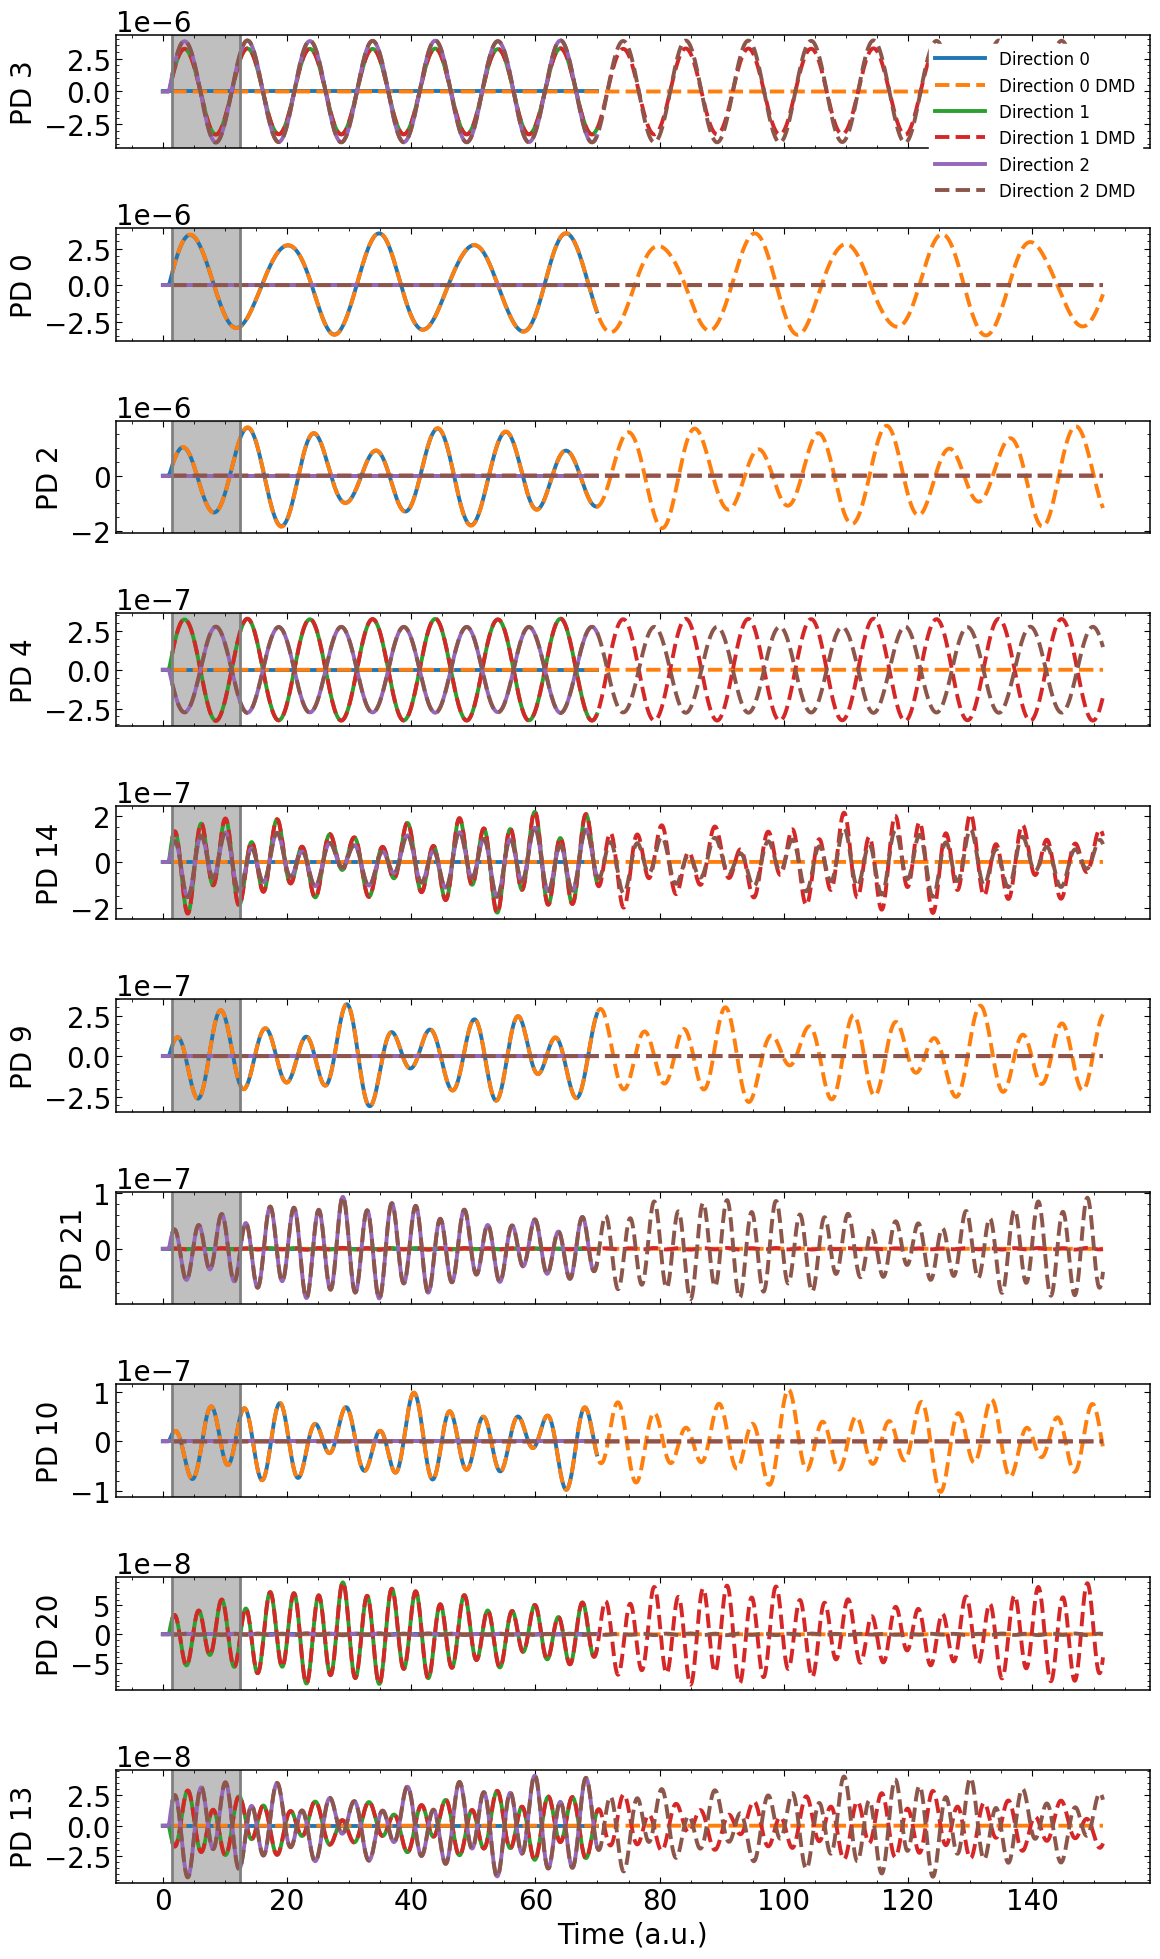

In [11]:
nfirst = 10
fig, axes = plt.subplots(nfirst, 1, figsize=(12, nfirst * 2), sharex=True)
plt.subplots_adjust(hspace=0.05)

time_array_extrap = np.arange(nsnap_extrap) * time_step + idmd_first * time_step

for i in range(nfirst):

    for idir in range(3):
        if i==0:
            label = f'Direction {idir}'
        else:
            label = None

        axes[i].plot(time_array, time_data[idir, idx[i], :], label=label)
        label_extrap = f'Direction {idir} DMD' if label is not None else None
        axes[i].plot(time_array_extrap, time_data_extrap_HO[idir, idx[i], :], label=label_extrap, linestyle='--')

    if i==0:
        axes[i].legend(loc='upper right', edgecolor='white', framealpha=1.0, fontsize=12)

    axes[i].set_ylabel(f'PD {idx[i]}')

    # Gray region from idmd_first to idmd_first + ndmd with bounds
    axes[i].axvline(idmd_first * time_step, color='gray', linestyle='-', lw=2.0)
    axes[i].axvline((idmd_first + ndmd) * time_step, color='gray', linestyle='-', lw=2.0)
    axes[i].axvspan(idmd_first * time_step, (idmd_first + ndmd) * time_step, color='gray', alpha=0.5)

axes[-1].set_xlabel('Time (a.u.)')

plt.tight_layout()
plt.show()

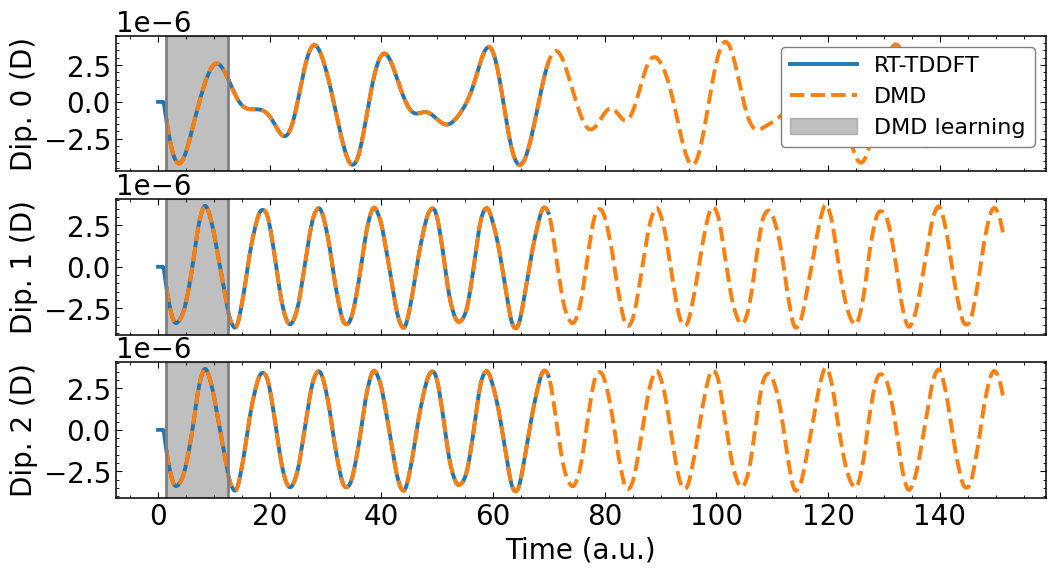

In [12]:
dipole_time_extrap_HO = compute_dipole_from_PD_MO(time_data_extrap_HO)

fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for idir in range(3):
    ax[idir].plot(time_array, dipole_time[idir, :], label='RT-TDDFT')
    ax[idir].plot(time_array_extrap, dipole_time_extrap_HO[idir, :], linestyle='--', label='DMD')
    ax[idir].set_ylabel(f'Dip. {idir} (D)')

    # Gray region from idmd_first to idmd_first + ndmd with bounds
    ax[idir].axvline(idmd_first * time_step, color='gray', linestyle='-', lw=2.0)
    ax[idir].axvline((idmd_first + ndmd) * time_step, color='gray', linestyle='-', lw=2.0)
    ax[idir].axvspan(idmd_first * time_step, (idmd_first + ndmd) * time_step, color='gray', alpha=0.5, label='DMD learning')

ax[0].legend(loc='upper right', edgecolor='gray', framealpha=1.0, fontsize=16)
ax[-1].set_xlabel('Time (a.u.)')
plt.show()

## Singular values

Text(0, 0.5, 'Singular value')

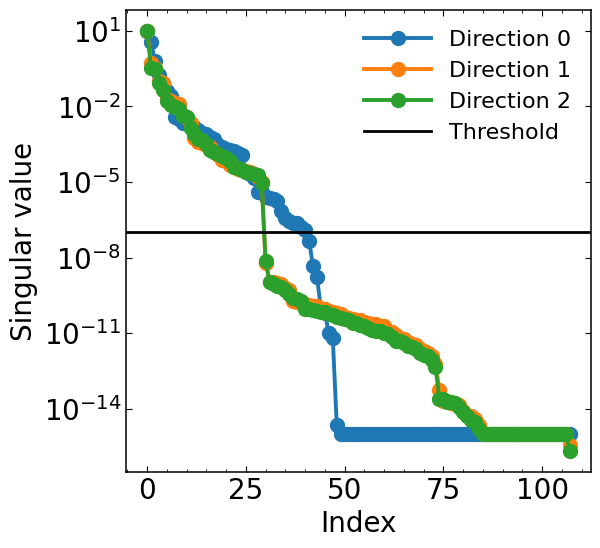

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for idir in range(3):
    sigma = HODMD_obj_list[idir].sigma_full_array
    ax.plot(sigma, marker='o', label=f'Direction {idir}')

threshold = HODMD_obj_list[0].sig_threshold
ax.axhline(threshold, color='black', linestyle='-', lw=2, label='Threshold')

ax.set_yscale('log')

ax.legend(loc='upper right', edgecolor='white', framealpha=1.0, fontsize=16)
ax.set_xlabel('Index')
ax.set_ylabel('Singular value')

## HODMD modes

mode_array.shape=(181, 41)
(3, 181, 700)
1 181


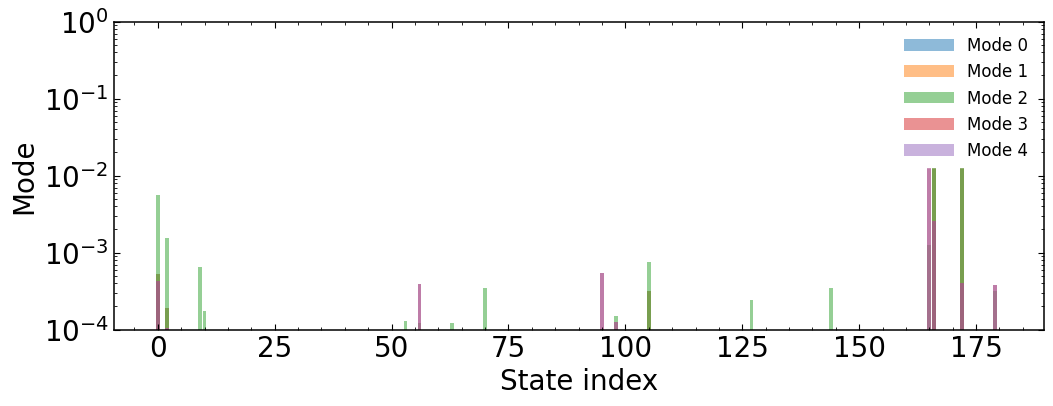

In [14]:
mode_array = HODMD_obj_list[0].mode_array
nmode = mode_array.shape[-1]

print(f'{mode_array.shape=}')

print(time_data.shape)
print(nocc, nvirt)

# reshape back to 3D
mode_array = mode_array.reshape((nocc, nvirt, nmode))

fig, ax = plt.subplots(1, 1, figsize=(12, 4))

nmode_plot = 5

for imode in range(nmode_plot):
    # For H2 and no spin, there is only one occupied state
    #ax.plot(np.abs(mode_array[:, :, imode].flatten()), label=f'Mode {imode}')

    # Plot as bars
    ax.bar(np.arange(nocc * nvirt), np.abs(mode_array[:, :, imode].flatten()), label=f'Mode {imode}', alpha=0.5)

ax.set_yscale('log')
ax.set_ylim(ymin=1.0e-4, ymax=1.0e0)

ax.legend(loc='upper right', edgecolor='white', framealpha=1.0, fontsize=12)
ax.set_xlabel('State index')
ax.set_ylabel('Mode')
plt.show()

## HODMD mode amplitudes

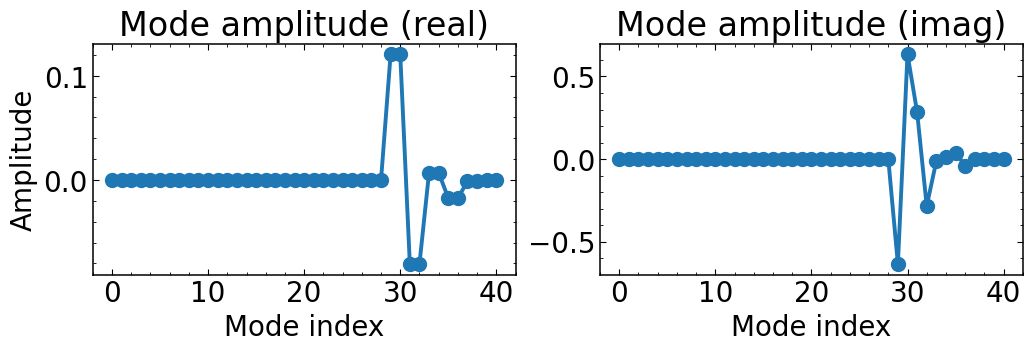

In [15]:
mode_ampl_array = HODMD_obj_list[0].mode_ampl_array
rank = HODMD_obj_list[0].rank

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

axes[0].plot(np.real(mode_ampl_array), marker='o')
axes[1].plot(np.imag(mode_ampl_array), marker='o')

axes[0].set_title('Mode amplitude (real)')
axes[1].set_title('Mode amplitude (imag)')

axes[0].set_xlabel('Mode index')
axes[1].set_xlabel('Mode index')
axes[0].set_ylabel('Amplitude')

plt.show()

# Extended DMD (EDMD)

In [25]:
time_data_extrap_EDMD = np.zeros((3, time_data.shape[1], nsnap_extrap), dtype=float)
EDMD_obj_list = []

for idir in range(3):
    dmd_obj = dmd.dmd(time_data[idir, :, idmd_first : idmd_first + ndmd], apply_scaling=True) #apply_scaling=False)

    dmd_obj.time_step = time_step
    dmd_obj.verbose = False

    dmd_obj.sig_threshold = 1e-11

    dmd_obj.HODMD_order = 2
    dmd_obj.HODMD_ntshift = 1

    dmd_obj.EDMD = True
    dmd_obj.EDMD_nfreq = 1000
    dmd_obj.EDMD_sigma = 10000
    # For reproducibility, set the random seed
    dmd_obj.EDMD_random_seed = 123

    dmd_obj.compute_modes()

    dmd_obj.nsnap_extrap = nsnap_extrap

    EDMD_obj_list.append(dmd_obj)

    time_data_extrap_EDMD[idir, :, :] = dmd_obj.extrapolate()

    if idir == 0 and save_data:

        with open('edmd_H2_extrap_array.npy', 'wb') as f:
            np.save(f, np.sum(time_data_extrap_EDMD[0, :, :], axis=0))

        with open('edmd_H2_omega_array.npy', 'wb') as f:
            np.save(f, dmd_obj.omega_array)

        with open('edmd_H2_mode_array.npy', 'wb') as f:
            np.save(f, dmd_obj.mode_array)

        with open('edmd_H2_mode_ampl_array.npy', 'wb') as f:
            np.save(f, dmd_obj.mode_ampl_array)

        with open('edmd_H2_sigma_full_array.npy', 'wb') as f:
            np.save(f, dmd_obj.sigma_full_array)

/var/folders/jh/mf_p4phx08740jfpp0d3f4_40000gn/T/ipykernel_63147/1372690901.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  time_data_extrap_EDMD[idir, :, :] = dmd_obj.extrapolate()


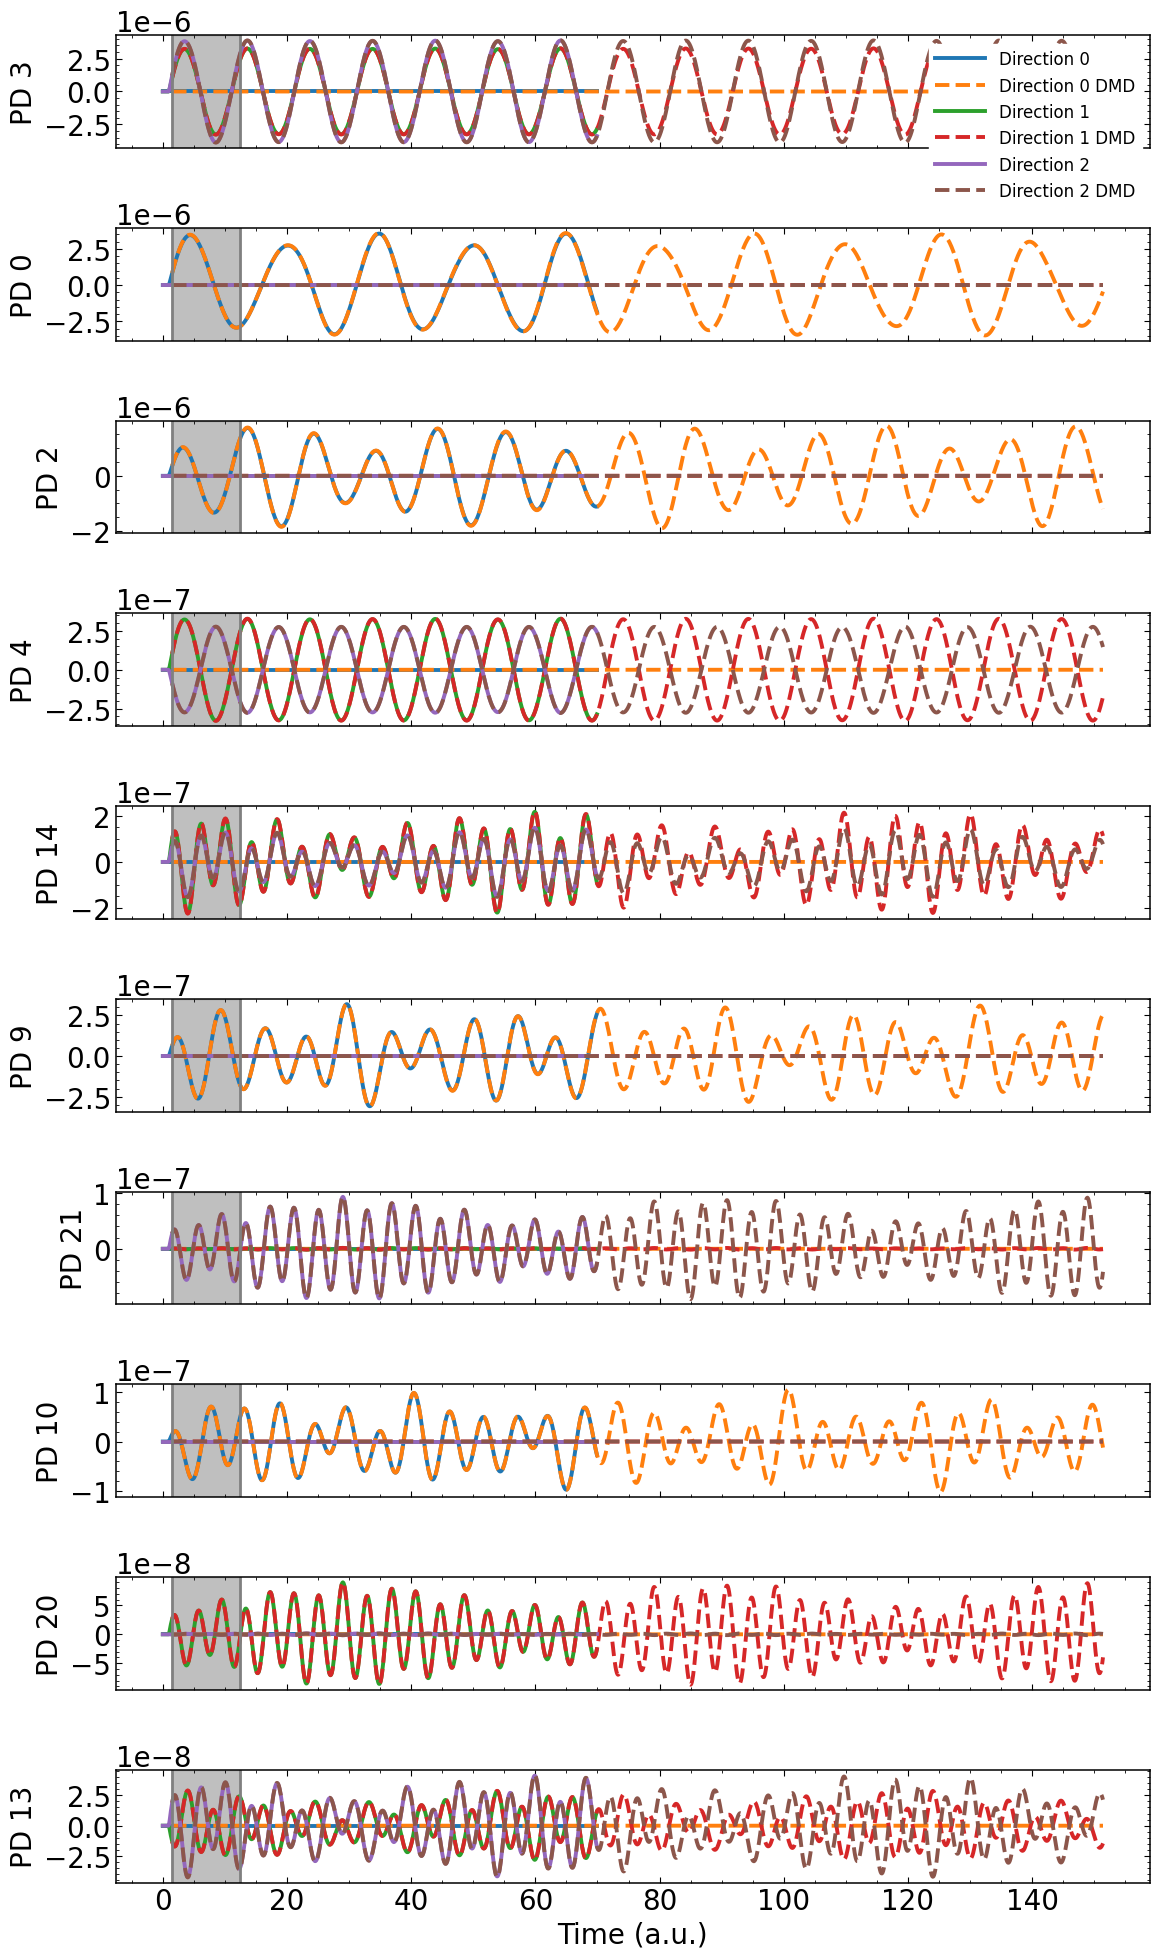

In [26]:
nfirst = 10
fig, axes = plt.subplots(nfirst, 1, figsize=(12, nfirst * 2), sharex=True)
plt.subplots_adjust(hspace=0.05)

time_array_extrap = np.arange(nsnap_extrap) * time_step + idmd_first * time_step

for i in range(nfirst):

    for idir in range(3):
        if i==0:
            label = f'Direction {idir}'
        else:
            label = None

        axes[i].plot(time_array, time_data[idir, idx[i], :], label=label)
        label_extrap = f'Direction {idir} DMD' if label is not None else None
        axes[i].plot(time_array_extrap, time_data_extrap_EDMD[idir, idx[i], :], label=label_extrap, linestyle='--')

    if i==0:
        axes[i].legend(loc='upper right', edgecolor='white', framealpha=1.0, fontsize=12)

    axes[i].set_ylabel(f'PD {idx[i]}')

    # Gray region from idmd_first to idmd_first + ndmd with bounds
    axes[i].axvline(idmd_first * time_step, color='gray', linestyle='-', lw=2.0)
    axes[i].axvline((idmd_first + ndmd) * time_step, color='gray', linestyle='-', lw=2.0)
    axes[i].axvspan(idmd_first * time_step, (idmd_first + ndmd) * time_step, color='gray', alpha=0.5)

axes[-1].set_xlabel('Time (a.u.)')

plt.tight_layout()
plt.show()

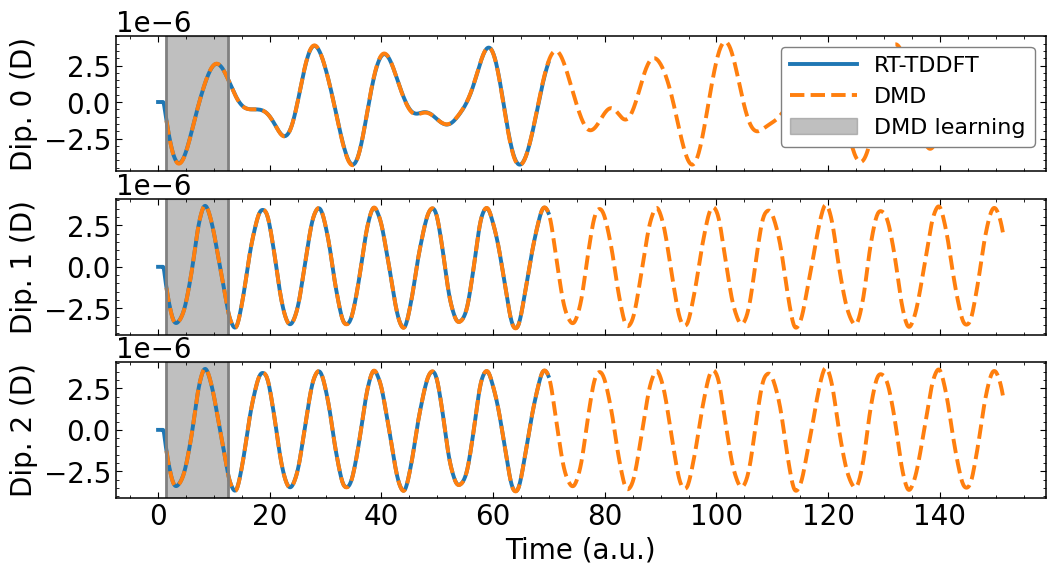

In [27]:
dipole_time_extrap_EDMD = compute_dipole_from_PD_MO(time_data_extrap_EDMD)

fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)

for idir in range(3):
    ax[idir].plot(time_array, dipole_time[idir, :], label='RT-TDDFT')
    ax[idir].plot(time_array_extrap, dipole_time_extrap_EDMD[idir, :], linestyle='--', label='DMD')
    ax[idir].set_ylabel(f'Dip. {idir} (D)')

    # Gray region from idmd_first to idmd_first + ndmd with bounds
    ax[idir].axvline(idmd_first * time_step, color='gray', linestyle='-', lw=2.0)
    ax[idir].axvline((idmd_first + ndmd) * time_step, color='gray', linestyle='-', lw=2.0)
    ax[idir].axvspan(idmd_first * time_step, (idmd_first + ndmd) * time_step, color='gray', alpha=0.5, label='DMD learning')

ax[0].legend(loc='upper right', edgecolor='gray', framealpha=1.0, fontsize=16)
ax[-1].set_xlabel('Time (a.u.)')
plt.show()